# 📘 Ejercicio 1 — Laberinto con BFS

Este notebook genera un **laberinto conectado** utilizando el algoritmo **DFS (Depth-First Search)** para crear los pasillos.
Posteriormente, aplica el algoritmo **BFS (Breadth-First Search)** para encontrar el **camino más corto** desde la celda de inicio
hasta la celda objetivo.

Durante la ejecución se muestran:

* El laberinto inicial con inicio (**verde**) y meta (**rojo**).
* Una animación del proceso de búsqueda:

  * Azul claro → celdas visitadas.
  * Amarillo → camino final más corto.
* La longitud del camino óptimo en pasos.

---




## Importamos librerías

In [1]:
import copy
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from IPython.display import HTML


## Generamos el laberinto con 1 y 0s

In [2]:
np.random.seed(42)
random.seed(42)

def generar_laberinto_conectado(filas, columnas):
    # Asegurar que filas y columnas sean impares para el algoritmo
    if filas % 2 == 0:
        filas += 1
    if columnas % 2 == 0:
        columnas += 1
        
    # Inicializar laberinto con todas las paredes
    laberinto = [['1' for _ in range(columnas)] for _ in range(filas)]
    visitado = [[False for _ in range(columnas)] for _ in range(filas)]
    
    def vecinos(x, y):
        dirs = [(-2,0),(2,0),(0,-2),(0,2)]
        result = []
        for dx, dy in dirs:
            nx, ny = x+dx, y+dy
            if 0 <= nx < filas and 0 <= ny < columnas and not visitado[nx][ny]:
                result.append((nx, ny))
        random.shuffle(result)
        return result
    
    def dfs(x, y):
        visitado[x][y] = True
        laberinto[x][y] = '0'
        
        for nx, ny in vecinos(x, y):
            if not visitado[nx][ny]:
                # Elimina la pared entre celdas
                laberinto[(x+nx)//2][(y+ny)//2] = '0'
                dfs(nx, ny)
    
    # Comenzar desde una posición impar (esquina superior izquierda válida)
    start_x, start_y = 1, 1
    if start_x < filas and start_y < columnas:
        dfs(start_x, start_y)
    
    # Crear algunas aberturas adicionales para hacer el laberinto más interesante
    # y asegurar que no queden áreas completamente aisladas
    for i in range(3, filas-1, 4):
        for j in range(3, columnas-1, 4):
            if random.random() < 0.3:  # 30% probabilidad de crear apertura
                if i > 0 and laberinto[i-1][j] == '1':
                    laberinto[i-1][j] = '0'
                elif j > 0 and laberinto[i][j-1] == '1':
                    laberinto[i][j-1] = '0'
    
    return laberinto

laberinto_conectado = generar_laberinto_conectado(20, 20)

for fila in laberinto_conectado:
    print(''.join(fila))





111111111111111111111
100000100010000010001
111010101010111010101
100000001000100000101
101111101111101111101
100000101000000000001
111110101110101111111
100000100000100010001
101111111010111011101
100000001010001000101
111011101110101110101
100000001000001010101
101010101011111010101
101010100010000010101
111010101110111010101
100010100000100010001
101110101011101111101
101000101010000010001
101111101010111110111
100000001000000000001
111111111111111111111


# Convertir el laberinto a un array NumPy para visualizarlo

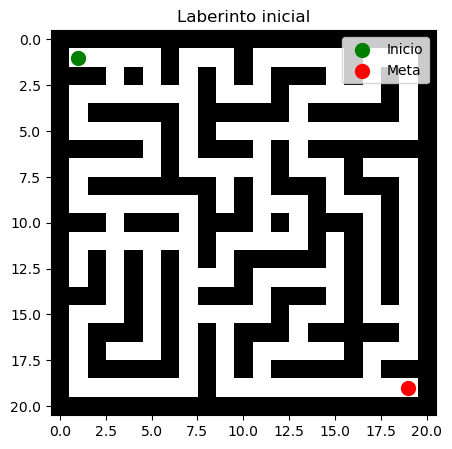

In [3]:
# Convertir el laberinto a array NumPy
maze = np.array([[int(c) for c in fila] for fila in laberinto_conectado])

# Definir inicio y meta
start = (1, 1)
goal = (maze.shape[0]-2, maze.shape[1]-2)

plt.figure(figsize=(5,5))
plt.imshow(maze, cmap="gray_r")
plt.title("Laberinto inicial")
plt.scatter(start[1], start[0], c="green", s=100, label="Inicio")
plt.scatter(goal[1], goal[0], c="red", s=100, label="Meta")
plt.legend()
plt.show()


# Calcula la ruta más corta


In [4]:
from collections import deque

def bfs(maze, start, goal):
    n, m = maze.shape
    visited = np.zeros_like(maze)
    parent = dict()
    queue = deque([start])
    visited[start] = 1
    order = []  # orden de visita
    
    while queue:
        x, y = queue.popleft()
        order.append((x,y))
        if (x, y) == goal:
            break
        for dx, dy in [(1,0),(-1,0),(0,1),(0,-1)]:
            nx, ny = x+dx, y+dy
            if 0 <= nx < n and 0 <= ny < m and maze[nx, ny] == 0 and not visited[nx, ny]:
                visited[nx, ny] = 1
                parent[(nx, ny)] = (x, y)
                queue.append((nx, ny))
    
    # Reconstruir camino
    path = []
    node = goal
    while node in parent:
        path.append(node)
        node = parent[node]
    path.append(start)
    path.reverse()
    return path, order

# Ejecutar BFS
path, order = bfs(maze, start, goal)
print(f"Longitud del camino óptimo: {len(path)-1} pasos")


Longitud del camino óptimo: 44 pasos


## Muestra el recorrido y animación de la ruta

In [5]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(6,6))
img = ax.imshow(maze, cmap="gray_r")

# Colores personalizados
colors = {
    0: (1,1,1),   # camino
    1: (0,0,0),   # muro
    2: (0.6,0.8,1), # visitado
    3: (1,1,0),   # camino final
    5: (0,1,0),   # inicio
    6: (1,0,0)    # meta
}

frames = []
for i, (x,y) in enumerate(order):
    frame = maze.copy()
    for j in range(i+1):
        vx, vy = order[j]
        frame[vx,vy] = 2
    frame[start] = 5
    frame[goal] = 6
    frames.append(frame)

# Frame final con el camino óptimo
final_frame = maze.copy()
for (x,y) in path:
    final_frame[x,y] = 3
final_frame[start] = 5
final_frame[goal] = 6
frames.append(final_frame)

def update(frame):
    data = np.zeros((*maze.shape, 3))
    for val, color in colors.items():
        data[frame == val] = color
    img.set_data(data)
    return [img]

ani = animation.FuncAnimation(fig, update, frames=frames, interval=100, blit=True, repeat=False)
plt.close()

HTML(ani.to_jshtml())




## 🚀 Pasos para ejecutar

1. Abre este notebook en **Jupyter Notebook** o **Jupyter Lab**.
2. Ejecuta todas las celdas en orden, desde la primera hasta la última.
3. El notebook generará automáticamente un laberinto, lo resolverá y mostrará:

   * Representación en texto (`1` = muro, `0` = camino).
   * Imagen inicial del laberinto con **inicio (verde)** y **meta (roja)**.
   * Una **animación** con la evolución de la búsqueda:

     * Azul claro → celdas visitadas.
     * Amarillo → camino final más corto.
     * Verde → inicio.
     * Rojo → meta.
   * La **longitud del camino óptimo** en pasos.

---

## ⚙️ Parámetros opcionales

### 🔸 Tamaño del laberinto

Puedes cambiar las dimensiones en la línea:

```python
laberinto_conectado = generar_laberinto_conectado(20, 20)
```

Ejemplo: `30, 30` o `25, 40`.
Si usas números pares, la función los ajustará automáticamente a impares.

### 🔸 Semilla aleatoria

El comportamiento del laberinto depende de la semilla:

```python
np.random.seed(42)
random.seed(42)
```

Cambia `42` por otro número para generar laberintos distintos.
Usar la misma semilla garantiza que el resultado sea **reproducible**.

---

## 🎯 Resultados esperados

* Se genera un laberinto conectado (sin islas).
* El BFS recorre las celdas mostrando el **progreso paso a paso**.
* Al finalizar, se dibuja en **amarillo** el camino más corto entre inicio y meta.
* En consola se imprime la **longitud del camino óptimo en pasos**.

Ejemplo de salida en consola:

```
Longitud del camino óptimo: 48 pasos
```

---

## 📦 Dependencias necesarias

Este notebook requiere únicamente las siguientes librerías de Python:

* `numpy`
* `matplotlib`

Si no las tienes instaladas, ejecútalo en la terminal:

```bash
pip install numpy matplotlib
```

---

✅ Con esto puedes ejecutar el notebook en cualquier máquina,
obteniendo siempre los mismos resultados si mantienes la misma semilla.
